This is the notebook for determining the overhead added by parameter control

It is divided into the main paragraphs:

- Data Preperation
- Model specification and execution

# Data Preperation


In [3]:
import pymc as pm
import pandas as pd
from utils.design_matrix_creator import get_design_matricies

data = pd.read_csv("../single_parameter/combined_data/statistics.csv")


observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'AlgorithmIterations')

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


# Model Specification

In [4]:
with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=7, sigma=0.5)
    
    # Standard Deviations for modules, parameters and interactions
    sigma_a = pm.Exponential('sigma_a', 4.0)
    sigma_b = pm.Exponential('sigma_b', 4.0)
    sigma_g = pm.Exponential('sigma_g', 4.0)
    
    # Non-centered parameterizations for module, parameter and interaction effect.
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=12)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=288)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct dummy variables
    log_a = pm.math.dot(module_matrix, a_m)
    log_b = pm.math.dot(parameter_matrix, b_p)
    log_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (log)
    mu = pm.Deterministic('mu', pm.math.exp(log_a + log_b + log_g))
    
    # Negative Binomial likelihood
    theta = pm.Gamma('theta', alpha=5.0, beta=0.1) # dispersion parameter
    Y_obs = pm.NegativeBinomial('Y_obs', n=theta, p=(theta)/(mu + theta), observed=observation_matrix['AlgorithmIterations'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4,return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Model building complete.")

Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_a, sigma_b, sigma_g, a_offset, b_offset, g_offset, theta]


Output()

Sampling 4 chains for 5 tune and 5 draw iterations (20 + 20 draws total) took 24 seconds.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


Output()

Model building complete.


### Save the results

In [ ]:
import arviz as az

az.to_netcdf(trace, "overhead_model_trace_single_param.nc")

In [1]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp


# Example usage
trace = az.from_netcdf("model_overhead_trace.nc")
variable_list = ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p']
transformations = {
    'a_m': log_to_exp,
    #'a_bar': log_to_exp,
    #'sigma_a': log_to_exp
    #'b_p': log_to_exp
}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
table = az.summary(idata, ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p'], hdi_prob=0.89)
table

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_m[0],1294.135,14.611,1270.833,1316.997,0.262,0.185,3117.0,2933.0,1.00
a_m[1],1683.978,19.091,1653.004,1712.977,0.333,0.236,3293.0,2954.0,1.00
a_m[2],1415.768,16.176,1390.296,1441.552,0.256,0.181,4019.0,3233.0,1.00
a_m[3],1509.082,16.733,1482.648,1535.760,0.263,0.186,4034.0,3406.0,1.00
a_m[4],1254.524,14.247,1231.719,1277.041,0.226,0.160,3962.0,3377.0,1.00
a_m[5],2097.908,23.501,2061.787,2137.286,0.392,0.277,3582.0,2782.0,1.00
a_m[6],1698.428,19.338,1667.144,1728.988,0.313,0.221,3758.0,3040.0,1.00
a_m[7],620.855,7.184,610.316,633.113,0.118,0.083,3720.0,3627.0,1.00
a_m[8],1101.980,12.562,1080.312,1120.513,0.209,0.148,3611.0,3085.0,1.00
a_m[9],1002.000,11.390,983.260,1019.842,0.179,0.127,4016.0,3379.0,1.00


array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>]],
      dtype=object)

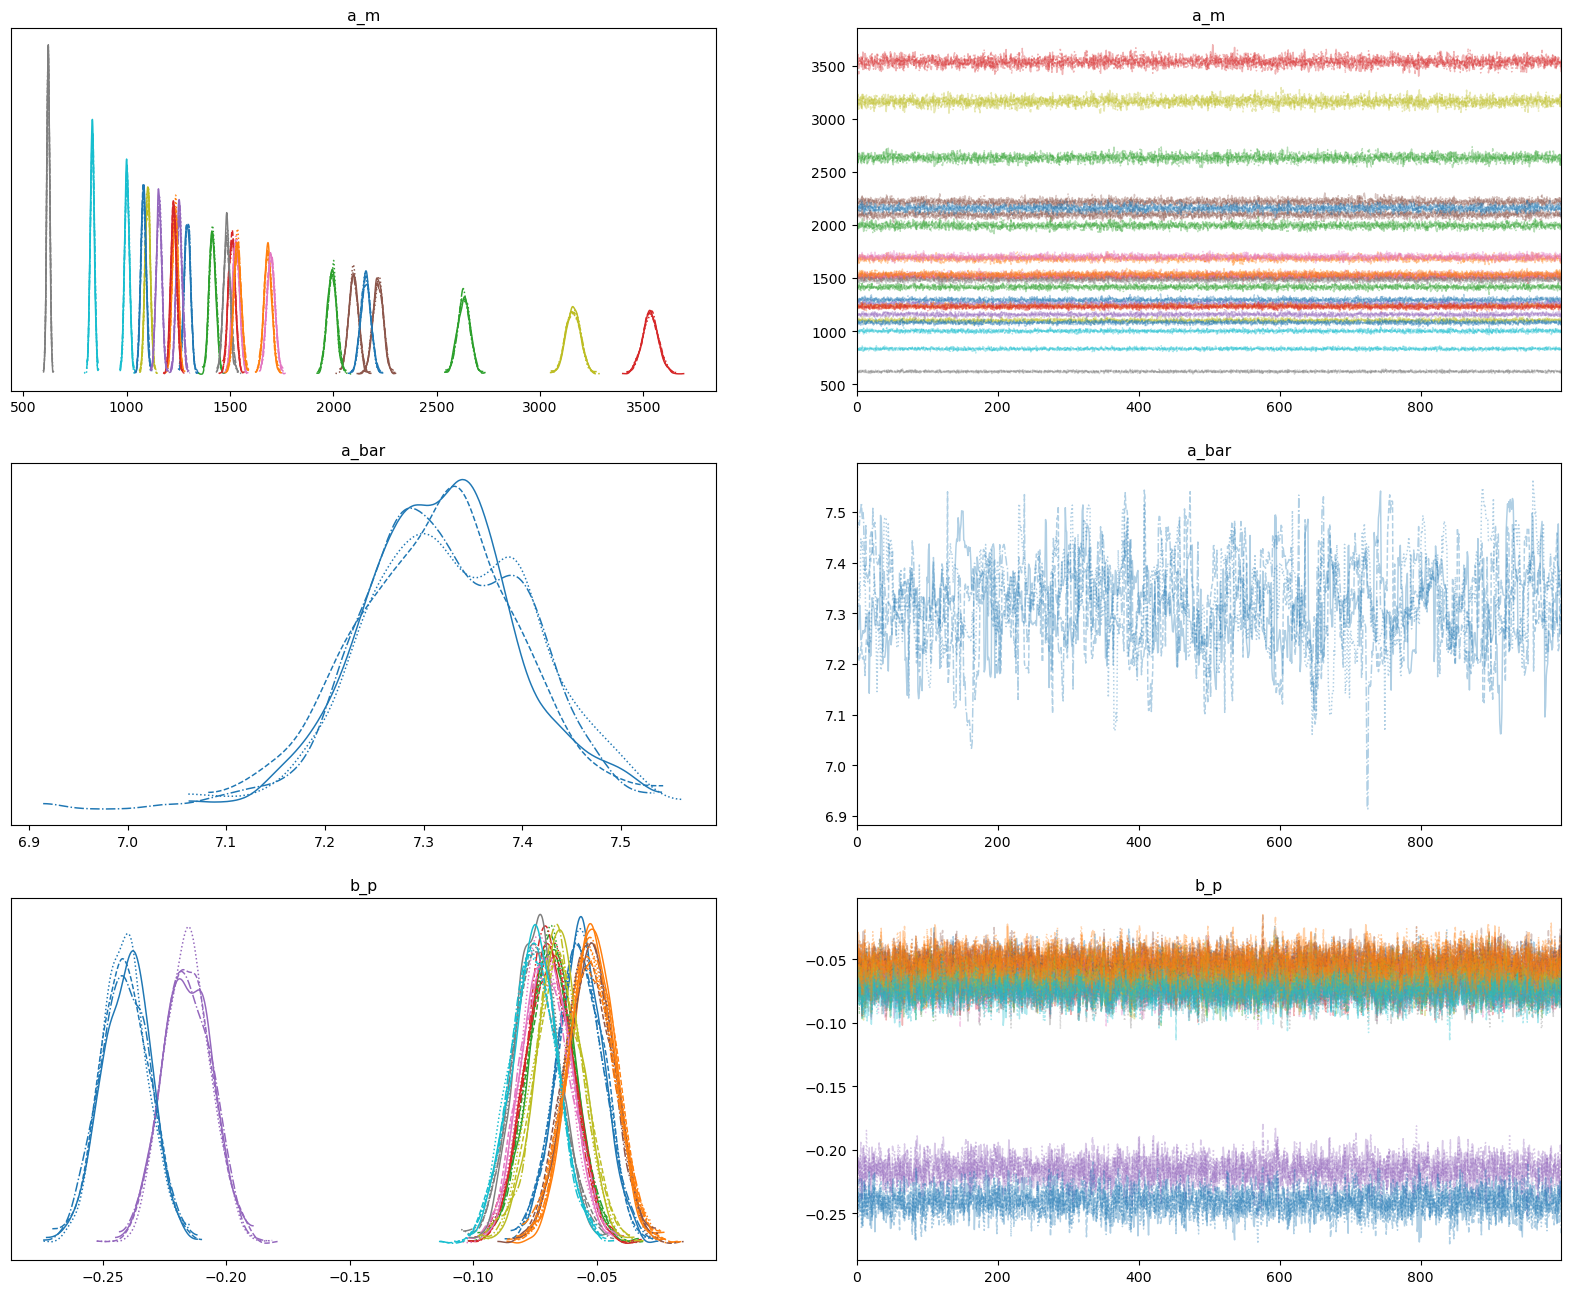

In [4]:
az.plot_trace(idata, var_names=['a_m', 'a_bar', 'b_p'], figsize=(20, 16))

In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def calc_prior_dist(s_a, s_b, s_g, a_bar_mu, a_bar_sigma):
    with pm.Model():
        # Global Intercept and standard deviation for Modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Modules, Parameters and Interactions
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Non-centered parameterizations
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)


        # Link function (logit), unbounded to (0,1) probability
        pm.Deterministic('mu_before', a_m + b_p + g_mp)
        pm.Deterministic('mu', pm.math.exp(a_m + b_p + g_mp))
        
        # Beta distribution likelihood 
        pm.Gamma('theta', alpha=5.0, beta=0.1)#pm.Uniform('theta', 5, 100)
        
        # Sample from the model
        idata = pm.sample_prior_predictive(samples=10000)



    # Fetch and flatten priors
    prior_mu= idata.prior['mu'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()

    simulated_observations = np.random.negative_binomial(n=prior_theta, p=(prior_theta)/(prior_mu + prior_theta))
    
    #Predicated observations
    plt.figure(figsize=(4, 3))

    observation_plot = HistogramPlot(simulated_observations,'Simulated Observations of Algorithm Iterations using priors ', 'Values',
                                     'darkcyan', bin_range=(0,8000))
    observation_plot.plot()


    plots = [
        HistogramPlot(idata.prior['mu_before'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'black'),
        HistogramPlot(idata.prior['mu'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'purple', bin_range=(0, 10000)),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior Distribution of theta - Uniform(10,200)', 'p_before', 'orange'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior Distribution of a_bar - Normal(0, 1.5)', 'a_bar', 'blue'),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'red'),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior Distribution of a_m - Normal(a_bar, sigma)', 'a_m', 'green'),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'salmon'),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'b_p', 'pink'),
        HistogramPlot(idata.prior['sigma_g'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'brown'),
        HistogramPlot(idata.prior['g_mp'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'g_mp', 'yellow')
    ]

    plot_histograms(plots, 5, 2, figsize=(10,20))


s_a = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
s_b = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
s_g = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_gamma (sigma_g):')
a_bar_mu = FloatSlider(value=7, min=0, max=10, step=0.1, description='alpha bar mu (a_bar_mu):')
a_bar_sigma = FloatSlider(value=0.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')



interact(calc_prior_dist, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma)
#calc_prior_dist(4,4,4,7,0.5)

interactive(children=(FloatSlider(value=4.0, description='Sigma_alpha (sigma_a):', max=6.0, min=0.5), FloatSli…

<function __main__.calc_prior_dist(s_a, s_b, s_g, a_bar_mu, a_bar_sigma)>